In [8]:
# In this file I can accurately determine the area of a the mesh using ray tracing
import shapely
import shapely.plotting
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection

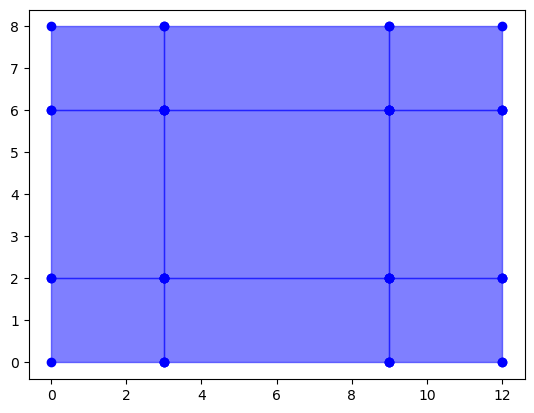

In [9]:
x_min = 0
x_max = 12
y_min = 0
y_max = 8

x_steps = [0, 3, 9, 12]
y_steps = [0, 2, 6, 8]

# create shapely boxes
cells = []
for i in range(len(x_steps)-1):
    for j in range(len(y_steps)-1):
        cells.append(shapely.geometry.box(x_steps[i], y_steps[j], x_steps[i+1], y_steps[j+1]))

fig, ax = plt.subplots()        
for cell in cells:
    # fig, ax = plt.subplots()
    # ax.set_xlim(x_min, x_max)
    # ax.set_ylim(y_min, y_max)
    shapely.plotting.plot_polygon(cell, color='blue', alpha=0.5, ax=ax)

tree = shapely.STRtree(cells)

In [10]:
def generate_ray(
    offset_from_center, line_angle, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max
):
    """Generates a ray an angle `line_angle` that is offset by `offset_from_center` from the center of the problem domain
    in the direction perpendicular to the line angle.
    The ray is bounded by the problem domain.
    Theta is in radians and counterclockwise from the x-axis.
    """
    sin_theta = np.sin(line_angle)
    cos_theta = np.cos(line_angle)
    tan_theta = sin_theta / cos_theta

    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2

    # technically not the offset but just a point on the ray we are generating
    x_offset = x_center + offset_from_center * sin_theta
    y_offset = y_center - offset_from_center * cos_theta

    # point intercept form, slope is tan(theta)
    y_of_x = lambda x: tan_theta * (x - x_offset) + y_offset
    x_of_y = lambda y: (y - y_offset) / tan_theta + x_offset

    # edge case where ray intersects corners of the problem domain
    if (
        np.abs(x_max - x_min) == np.abs(y_max - y_min)
        and np.abs(line_angle) == np.pi / 4
        and offset_from_center == 0
    ):
        if line_angle > 0:
            return shapely.geometry.LineString([(x_min, y_min), (x_max, y_max)])
        else:
            return shapely.geometry.LineString([(x_min, y_max), (x_max, y_min)])

    # Calculate the intersection points with the problem domain boundaries
    points = []
    y_of_x_min = y_of_x(x_min)
    if y_min <= y_of_x_min <= y_max:
        points.append((x_min, y_of_x_min))

    y_of_x_max = y_of_x(x_max)
    if y_min <= y_of_x_max <= y_max:
        points.append((x_max, y_of_x_max))

    x_of_y_min = x_of_y(y_min)
    if x_min <= x_of_y_min <= x_max:
        points.append((x_of_y_min, y_min))

    x_of_y_max = x_of_y(y_max)
    if x_min <= x_of_y_max <= x_max:
        points.append((x_of_y_max, y_max))

    if len(points) == 0:
        return None

    assert (
        len(points) == 2
    ), f"Ray does not intersect the problem domain twice. It does {len(points)} times. Points: {points}"

    # Create a line string representing the ray
    ray = shapely.geometry.LineString(points)

    return ray

In [11]:
def get_intersecting_cells(ray, tree: shapely.STRtree):
    cell_idxs = tree.query(ray, predicate="intersects")
    cells = [tree.geometries.take(i) for i in cell_idxs]
    return cells

In [ ]:
class CellData:
    def __init__(self, cell: shapely.geometry.Polygon):
        self.cell = cell

        # self.angle_to_area = {}
        self.area = cell.area
        self.approximate_area = 0.0
        
    def add_approximate_area(self, area: float):
        self.approximate_area += area
        

In [25]:
ray_width = 0.1
test_max_offset = max([x_max - x_min, y_max - y_min]) * 3/2 # generating a whole lot of extra rays

angle = -np.pi / 3
cells_data = {cell: CellData(cell) for cell in cells}


rays = []
for offset in np.arange(-test_max_offset, test_max_offset, ray_width):
    ray = generate_ray(offset, angle)
    if ray is not None:
        rays.append(ray)

for ray in rays:
    intersecting_cells = get_intersecting_cells(ray, tree)
    for cell in intersecting_cells:
        intersection = ray.intersection(cell)
        area = intersection.length * ray_width
        cells_data[cell].add_approximate_area(area)

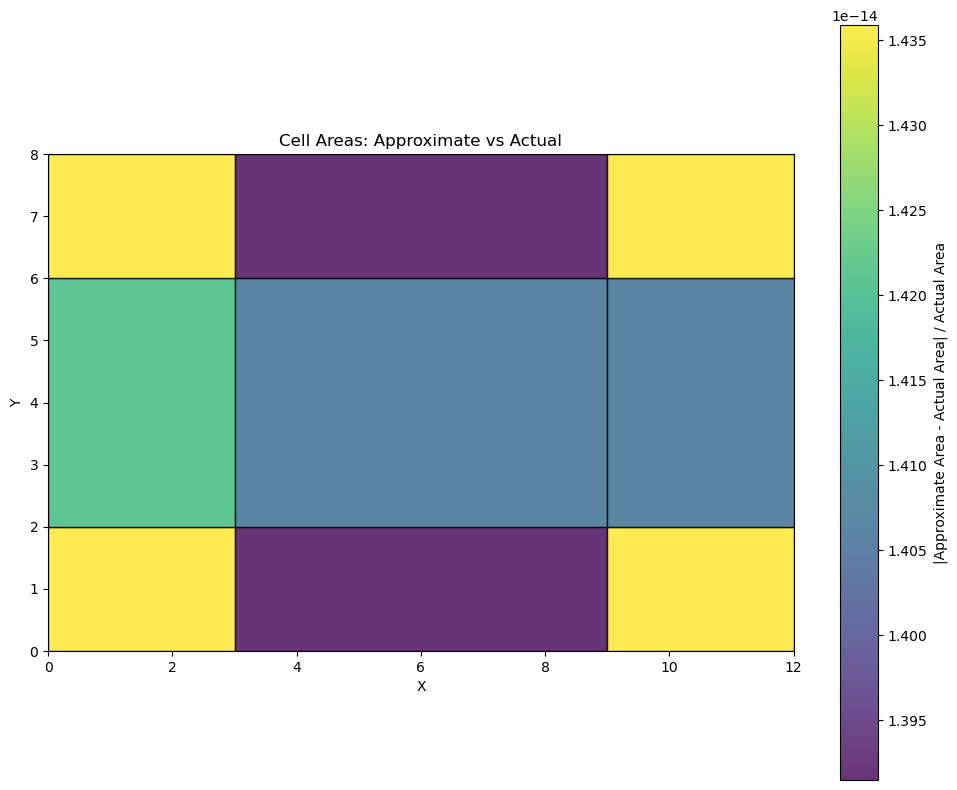

In [27]:
# Create a new cell with this code:
fig, ax = plt.subplots(figsize=(10, 8))

# Extract values to plot (using the ratio of approximate to actual area)
values = [np.abs(cells_data[cell].approximate_area - cells_data[cell].area)/cells_data[cell].area for cell in cells]

# Create a polygon collection with a color mapping
patches = []
for cell in cells:
    patches.append(mpatches.Polygon(list(cell.exterior.coords)))

# Create the PatchCollection
p = PatchCollection(
    patches, cmap="viridis", alpha=0.8, edgecolors="black", linewidths=1
)

# Set the array that determines colors
p.set_array(np.array(values))

# Add the collection to the plot
ax.add_collection(p)

# Add a colorbar
cbar = plt.colorbar(p, ax=ax)
cbar.set_label("|Approximate Area - Actual Area| / Actual Area")

# Set plot limits
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_aspect("equal")

# Add title and labels
plt.title("Cell Areas: Approximate vs Actual")
plt.xlabel("X")
plt.ylabel("Y")

plt.tight_layout()
plt.show()